In [15]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn
import random
import operator

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Reinforcement Learning

Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

Reinforcement learning differs from supervised learning in not needing labelled input/output pairs be presented, and learning to act under evaluative feedback (rewards). Instead the focus is on finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

The environment is typically stated in the form of a Markov decision process (MDP), because many reinforcement learning algorithms for this context utilize dynamic programming techniques. The main difference between the classical dynamic programming methods and reinforcement learning algorithms (that involve ANNs) is that the latter do not assume knowledge of an exact mathematical model of the MDP and they target large MDPs where exact methods become infeasible.

---

Reinforcement learning is *Agent-oriented learning*, that is learning by interacting with an environment to achieve a goal. Which is learning by trial and error, with only delayed evaluative feedback (reward).

However RL does have some challenges:
* We only have a reward signal as feedback
* Feedback is often delayed
* Time matters, sequential and non-stationary data
* Data received is affected by the agents previous interactions

It has been applied successfully to various problems, including robot control, power control, telecommunications, backgammon, checkers and Go.

## Problem formulation as a Markov Decision Process (MDP)

Often we consider the problem of making a sequence of good decisions. That is in a discrete setting, an agent will make sequence of **actions** $\{a_t\}$, observe a sequence of **observations** $\{o_t\}$ and receive a sequence of **rewards** $\{r_t\}$. We define the **history** at time $t$ to be $h_t = (a_1, o_1, r_1, \dots, a_t, o_t, r_t)$. The agent's function of the history, that is, $a_{t+1} = f(h_t)$, and the problem of sequential decision making can be thought of as defining and computing the function $f$ appropriately.

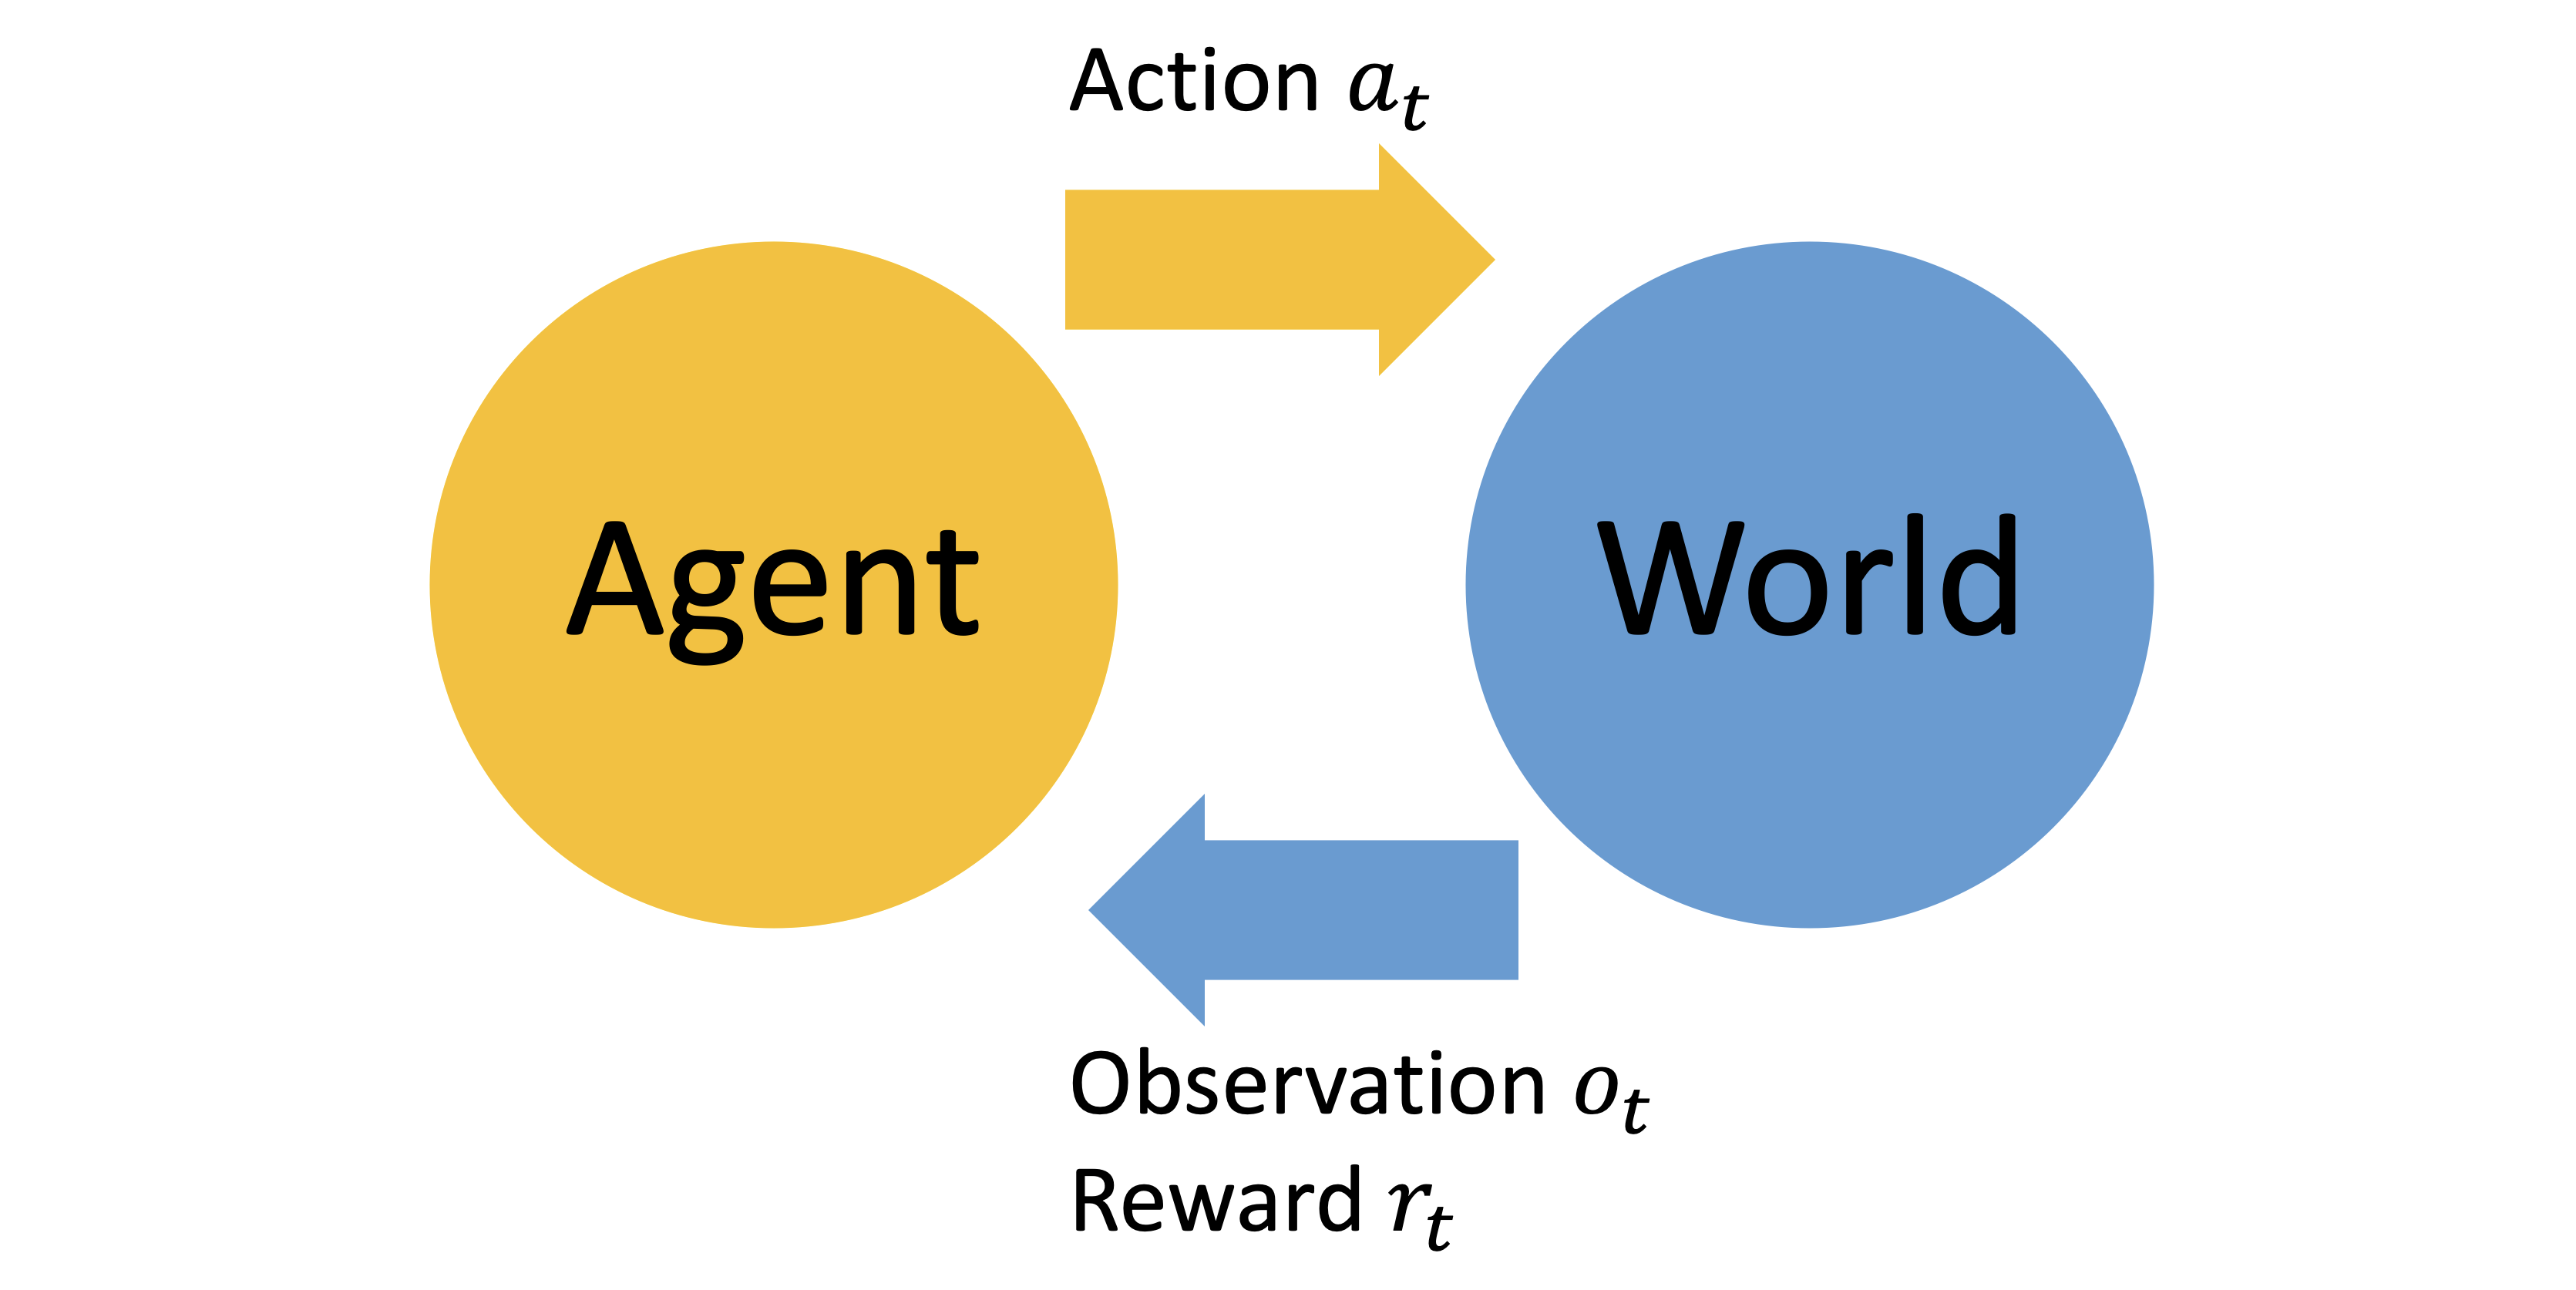


At each step $t$ the agent (as illustrated above) executes action $a_t$, receives observation $o_t$ and receives a scalar reward $r_t$. The environment receives action $a_t$, emits observation $o_{t+1}$ and emits a scalar reward $r_{t+1}$.

Our world may be in a state of possible states ($S$), however the agent observes a sequence of states $\{s_t\}$. We often want to consider the **transition dynamics** of the world $P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)$, a probability distribution over $S$ conditioned on the previous states and actions. In RL, we often assume the **Markov property** that

$$ P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)=P(s_{t+1}|s_t,a_t) $$

We can use the trick to make sure the Markov property holds, by using the history $h_t$ as our state. Usually, we consider the reward $r_t$ to be received on the transition between states, $s_t \xrightarrow{a_t} s_{t+1}$. A reward function is used to predict rewards, $R(s, a, s′) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a, s+{t+1} = s′]$. We will often consider the reward function to be of the form $R(s) = \mathop{\mathbb{E}}[r_t|s_t = s]$ or $R(s, a) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a]$. A **model** consists of the above transition dynamics and reward function.

The **agent state** is a function of the history, $s^a_t = g(h_t)$, a RL agent typically has an explicit representation of one or more of the following three things, a policy, a value function and optionally a model. A **policy** $\pi$ is a mapping from the agent state to an action, $\pi(s^a_t)\in A$,
or, sometimes it is a stochastic distribution over actions $\pi(a_t|s^a_t)$. When the agent wants to take an action and $\pi$ is stochastic, it picks action $a \in A$ with probability $P(a_t = a) = \pi(a|s^a_t)$. Given a policy $\pi$ and discount factor $\gamma \in [0, 1]$, a **value function** $V^{\pi}$ is an expected sum of discounted rewards (e.g. how good is each state, can also include action),


$$ V^\pi(s) = \mathop{\mathbb{E}_\pi}[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots | s_t = s]$$




Where $\mathop{\mathbb{E}_\pi}$ denotes that the expectation is taken over states encountered by following policy $\pi$, and, the discount factor $\gamma$ is used to weigh immediate rewards versus delayed rewards. Lastly, if the agent has a model, we would call it a **model-based** agent, and if it doesn't incorporate a model (agent's representation of the environment), we would call it a **model-free** agent.

For the case where $o_t\neq s_t$ **partially observable**, and it is common in partially observable settings for RL algorithms to maintain a probability distribution over the true world state to define $s^a_t$ , which is known as a **belief state**. However for majority of cases we will consider the fully observable case, where $o_t = s+t$, and will assume that $s^a_t = s_t$.

# Markov Decision Process (MDP)

Here a Markov decision process (MDP) is a discrete time stochastic control process. It provides a mathematical framework for modeling decision making in situations where outcomes are partly random and partly under the control of a decision maker. It is fully defined by the tuple of $(S, A, P, R, \gamma)$:
* $S$ Set of all possible states
* $A$ Set of all possible actions
* $R$ distribution of reward given (state, action) pair
* $P$ transition probability (of the world) i.e. distribution over next state given (state, action) pair
* $\gamma$ discount factor

The core problem of MDPs is to find a **policy** for the agent: a function $\pi$ that specifies the action $\pi(s)$ that the agent will choose when in state $s$. Once a Markov decision process is combined with a policy in this way, this fixes the action for each state and the resulting combination behaves like a Markov chain (since the action chosen in state $s$ is completely determined by $\pi(s)$ and $\Pr(s_{t+1}=s' \mid s_t = s, a_t=a)$ reduces to $\Pr(s_{t+1}=s' \mid s_t = s)$, a Markov transition matrix).

The goal is to choose a policy $\pi$ that will maximize some cumulative function of the random rewards, typically the expected discounted sum over a potentially infinite horizon. Hence the optimal policy $\pi^*$ is given by:

$$\pi^* = \operatorname{arg max}_{\pi} \mathop{\mathbb{E}}[\sum^{\infty}_{t=0} {\gamma^t R (s_t, a_t, s_{t+1})}] $$

$$ V^*(s) = \operatorname{arg max}_\pi V_{\pi^*}(s)$$

(where we choose $a_t = \pi(s_t)$, i.e. actions given by the policy). And the expectation is taken over $s_{t+1} \sim P_{a_t}(s_t,s_{t+1})$

where $\ \gamma \ $ is the discount factor satisfying $0 \le\ \gamma\ \le\ 1$, which is usually close to 1.

Because of the Markov property, the optimal policy for this particular problem can indeed be written as a function of $s$ only, as assumed above.

The discount-factor motivates the agent to favor taking actions early, rather not postpone them indefinitely.

This optimal policy can be found through a variety of methods, like dynamic programming. Some solutions require knowledge of the state transition function $P$ (**model**) and the reward function $R$. Others can solve for the optimal policy of an MDP using experimentation alone. 

The standard family of algorithms to calculate this optimal policy requires storage for two arrays indexed by state: **value** $V$, which contains real values, and **policy** $\pi$, which contains actions. At the end of the algorithm, $\pi$ will contain the solution and $V(s)$ will contain the discounted sum of the rewards to be earned (on average) by following that solution from state $s$.

The algorithm has two steps, (1) a value update and (2) a policy update, which are repeated in some order for all the states until no further changes take place.  Both recursively update 
a new estimation of the optimal policy and state value using an older estimation of those values (where $s'=s_{t+1}$).

$$V(s) := \sum_{s'} P_{\pi(s)} (s,s') \left( R_{\pi(s)} (s,s') + \gamma V(s') \right)$$

$$\pi(s) := \operatorname{argmax}_a \left\{ \sum_{s'} P(s' \mid s, a) \left( R(s'\mid s,a) + \gamma V(s') \right) \right\} $$

Their order depends on the variant of the algorithm; one can also do them for all states at once or state by state, and more often to some states than others. As long as no state is permanently excluded from either of the steps, the algorithm will eventually arrive at the correct solution. Some of variants are:

## Value iteration

In value iteration, which is also called backward induction,
the $\pi$ function is not used; instead, the value of $\pi(s)$ is calculated within $V(s)$ whenever it is needed. Substituting the calculation of $\pi(s)$ into the calculation of $V(s)$ gives the combined

$$ V_{i+1}(s) := \max_a \left\{ \sum_{s'} P(s,a,s') \left( R(s,a,s') + \gamma V_i(s') \right) \right\}, $$

where $i$ is the iteration number. Value iteration starts at $i = 0$ and $V_0$ as a guess of the value function. It then iterates, repeatedly computing $V_{i+1}$ for all states $s$, until $V$ converges with the left-hand side equal to the right-hand side (which is the *Bellman equation* for this problem).

## Policy iteration

In policy iteration, step one is performed once, and then step two is repeated until it converges. Then step one is again performed once and so on.

Instead of repeating step two to convergence, it may be formulated and solved as a set of linear equations. These equations are merely obtained by making $s = s'$ in the step two equation. Thus, repeating step two to convergence can be interpreted as solving the linear equations by Relaxation (iterative method).

This variant has the advantage that there is a definite stopping condition: when the array $\pi$ does not change in the course of applying step 1 to all states, the algorithm is completed.

Policy iteration is usually slower than value iteration for a large number of possible states. It takes $O(n^3)$ time to solve for $n$ states, making impractical for large state spaces.


Lets illustrate these with a MDP example, we can first create a MDP class

# MDP example

In [16]:
class BaseMDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. """

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""

        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

        
class MDP(BaseMDP):
    def __init__(self, init, terminals, transition_matrix, reward = None, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix[state])
        actlist = list(set(actlist))
        BaseMDP.__init__(self, init, actlist, terminals, transition_matrix, reward, gamma=gamma)

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else: 
            return self.transitions[state][action]

Lets implement the simple MDP in the image below. States A, B have actions X, Y available in them. Their probabilities are shown just above the arrows. We start with using BaseMDP as base class for our CustomMDP. Obviously we need to make a few changes to suit our case. We make use of a transition matrix as our transitions are not very simple.

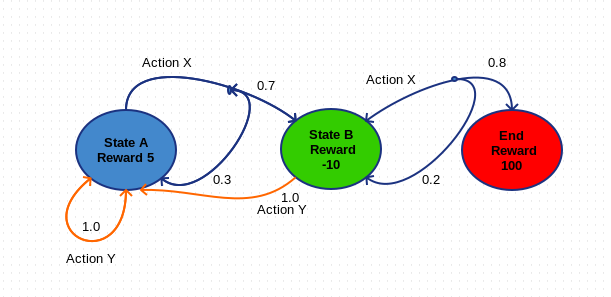

In [17]:
# Transition Matrix as nested dict. State -> Actions in state -> List of (Probability, State) tuples
t = {
    "A": {
            "X": [(0.3, "A"), (0.7, "B")],
            "Y": [(1.0, "A")]
         },
    "B": {
            "X": {(0.8, "End"), (0.2, "B")},
            "Y": {(1.0, "A")}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100
}

mdp_1 = MDP(init, terminals, t, rewards, gamma=.9)

## Value Iteration

In [18]:
def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration"""
    history = []
    V1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        V = V1.copy()
        history.append(V)
        delta = 0
        for s in mdp.states:
            V1[s] = R(s) + gamma * max(sum(p * V[s1] for (p, s1) in T(s, a))
                                       for a in mdp.actions(s))
            delta = max(delta, abs(V1[s] - V[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return V, pd.DataFrame(history)

In [19]:
V, history = value_iteration(mdp_1)
print(V)

{'B': 75.60975599852492, 'End': 100.0, 'A': 72.10147625879485}


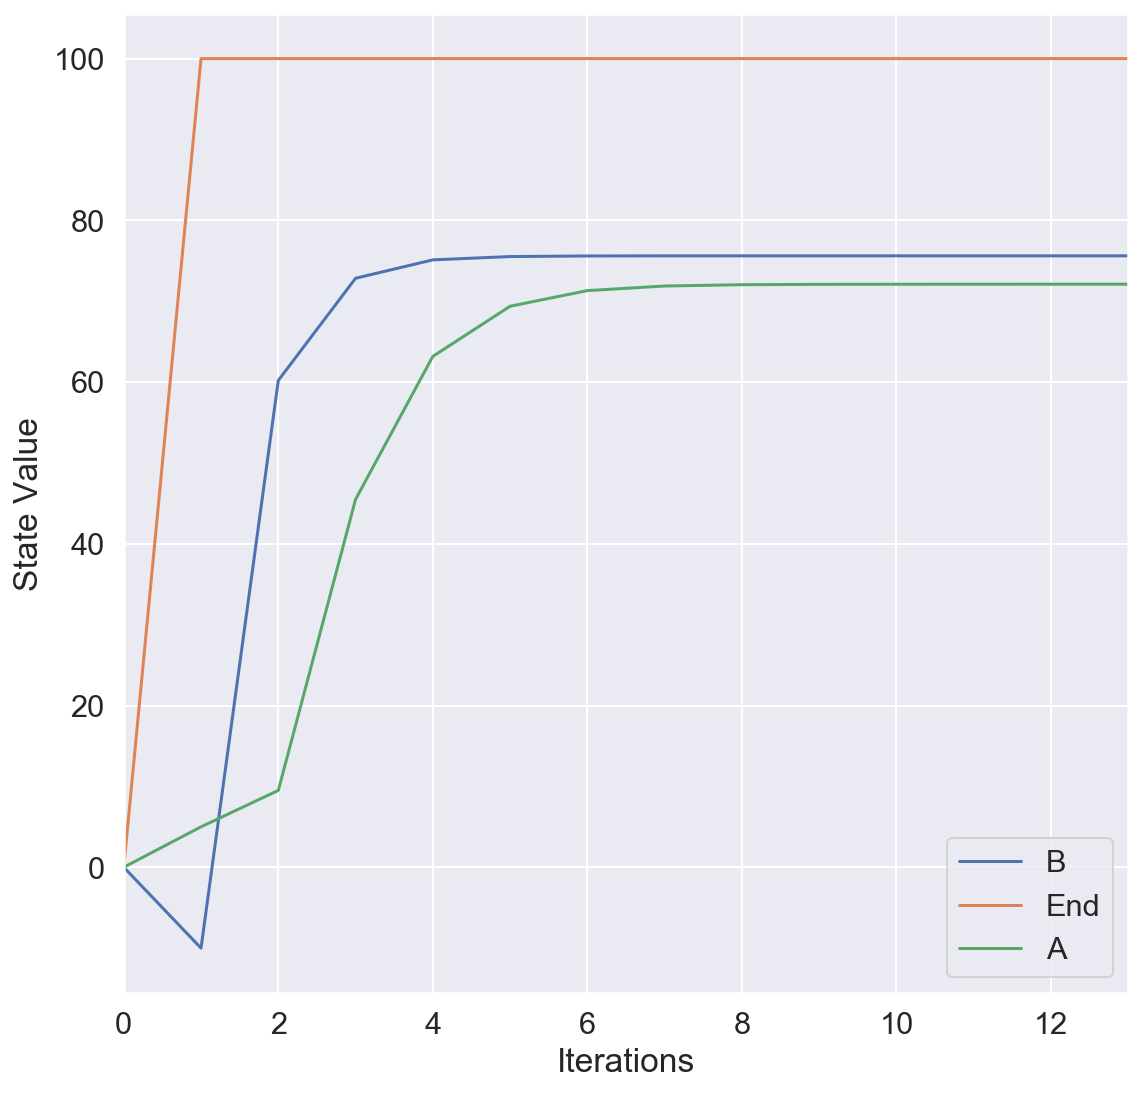

In [20]:
history.plot()
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()

## Policy Iteration

In [21]:
def expected_value(a, s, V, mdp):
    """The expected value of doing a in state s, according to the MDP and V."""

    return sum(p * V[s1] for (p, s1) in mdp.T(s, a))

def policy_evaluation(pi, V, mdp, k=20):
    """Return an updated value mapping V from each state in the MDP to its
    value, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            V[s] = R(s) + gamma * sum(p * V[s1] for (p, s1) in T(s, pi[s]))
    return V

def policy_iteration(mdp):
    """Solve an MDP by policy iteration"""

    history = []
    V = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        V = policy_evaluation(pi, V, mdp)
        history.append(V)
        unchanged = True
        for s in mdp.states:
            a = max(mdp.actions(s), key=lambda a: expected_value(a, s, V, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi, V, pd.DataFrame(history)

In [22]:
pi, V, history = policy_iteration(mdp_1)
print('Value Function: \n', V)
print('\nPolicy: \n', pi)

Value Function: 
 {'B': 75.60975609756098, 'End': 100.0, 'A': 72.10157033065235}

Policy: 
 {'B': 'X', 'End': None, 'A': 'X'}


# Reinforcement Learning

## Passive Reinforcement Learning

For Passive Reinforcement Learning the agent follows a fixed policy $\pi$. It attempts to evaluate a given policy $\pi$ - without any knowledge of the Reward function $R(s)$ and the Transition model $P(s_{t+1}|s_t,a_t)$.

This is achieved by **value estimation**, where the agent attempts to directly learn the value of each state that would result from following the policy. Although at each step, it has to *perceive* the reward and the state - it has no global knowledge of these. Thus, if a certain the entire set of actions offers a very low probability of attaining some state $s_+$ - the agent may never perceive the reward $R(s_+)$.

For a series of actions given by $\pi$, the estimated value $V$:

$$V^{\pi}(s) = \mathop{\mathbb{E}_\pi}[\sum_{t=0}^\infty \gamma^t R^t(s')]$$

Or the expected value of summed discounted rewards until termination.

Based on this concept, we discuss three methods of estimating the value:

1. **Direct Value Estimation (DVE)**
 
 The first, most naive method of estimating value comes from the simplest interpretation of the above definition. We construct an agent that follows the policy until it reaches the terminal state. At each step, it logs its current state, reward. Once it reaches the terminal state, it can estimate the value for each state for *that* iteration, by simply summing the discounted rewards from that state to the terminal one.

 It can now run this *simulation* $n$ times, and calculate the average value of each state. If a state occurs more than once in a simulation, both its value values are counted separately.
 
 Note that this method may be prohibitively slow for very large state spaces. Besides, **it pays no attention to the transition probability model $P(s_{t+1}|s_t,a_t)$.** It misses out on information that it is capable of collecting (say, by recording the number of times an action from one state led to another state). The next method addresses this issue.
 
2. **Adaptive Dynamic Programming (ADP)**
 
 This method makes use of knowledge of the past state $s_t$, the action $a_t$, and the new perceived state $s_{t+1}$ to estimate the transition probability model $P(s_{t+1}|s_t,a_t)$. It does this by the simple counting of new states resulting from previous states and actions.
 The program runs through the policy a number of times, keeping track of:
 * each occurrence of state $s_t$ and the policy-recommended action $a_t$ in $N_{s_t, a_t}$ (table of frequencies for state-action pairs, initially zero)
 * each occurrence of $s_{t+1}$ resulting from $a_t$ on $s_t$ in $N_{s_{t+1}|s_t, a_t}$. (table of outcome frequencies given state-action pairs, initially zero)
     
 It can thus estimate $P(s_{t+1}|s_t,a_t)$ as $N_{s_{t+1}|s_t, a_t}/N_{s_t, a_t}$, which in the limit of infinite trials, will converge to the true value.
 Using the transition probabilities thus estimated, it can apply **Policy Evaluation** to estimate the values $V(s)$ using properties of convergence of the Bellman functions.

3. **Temporal-difference learning (TD)**
 
 Instead of explicitly building the transition model $P$, the temporal-difference model makes use of the expected closeness between the values of two consecutive states $s_{t}$ and $s_{t+1}$.
 For the transition $s_t$ to $s_{t+1}$, the update is written as:
 
$$V^{\pi}(s) \leftarrow V^{\pi}(s) + \alpha \left( R(s) + \gamma V^{\pi}(s') - V^{\pi}(s) \right)$$
 This model implicitly incorporates the transition probabilities by being weighed for each state by the number of times it is achieved from the current state. Thus, over a number of iterations, it converges similarly to the Bellman equations.
 The advantage of the TD learning model is its relatively simple computation at each step, rather than having to keep track of various counts.
 For $n_s$ states and $n_a$ actions the ADP model would have $n_s \times n_a$ numbers $N_{s_t, a_t}$ and $n_s^2 \times n_a$ numbers $N_{s_{t+1}|s_t, a_t}$ to keep track of. The TD model must only keep track of a value $V(s)$ for each state.
 
## Example

Lets create a new MDP class to represent a grid world MDP. Here assuming that the environment is fully observable, so that the agent always knows where it is. The rewards are **+1** and **-1** in the terminal states, and **-0.04** in the rest (to help learn the shortest route).

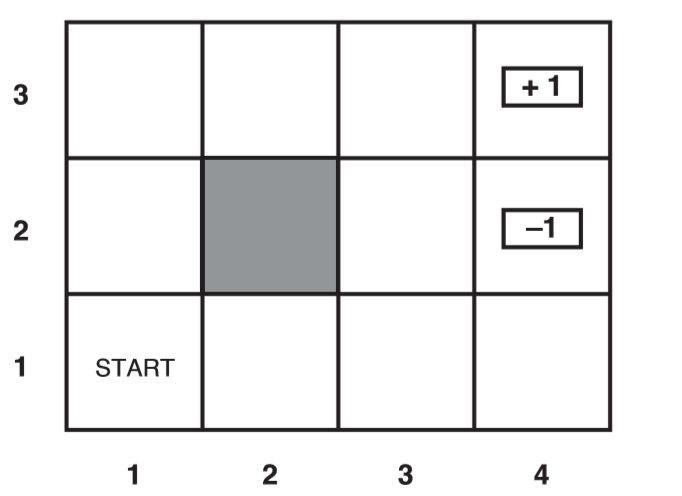

> This is the environment for our agent.

We also assume that the transitions are **Markovian**, that is, the probability of reaching state $s_{t+1}$ from state $s_t$ depends only on $s_t$ and not on the history of earlier states.
Almost all stochastic decision problems can be reframed as a Markov Decision Process just by tweaking the definition of a state for that particular problem.

However, the actions of our agent in this environment are unreliable. In other words, the motion of our agent is stochastic. 

More specifically, the agent may:
* move correctly in the intended direction with a probability of $0.8$  
* move $90^\circ$ to the right of the intended direction with a probability $0.1$
* move $90^\circ$ to the left of the intended direction with a probability $0.1$

The agent stays put if it bumps into a wall.

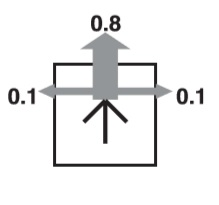

For any given state, the actions the agent can take are encoded as given below:
- Move Up: (0, 1)
- Move Down: (0, -1)
- Move Left: (-1, 0)
- Move Right: (1, 0)
- Do nothing: `None`


In [24]:
orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)


def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)


def turn_left(heading):
    return turn_heading(heading, LEFT)

def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))

class GridMDP(BaseMDP):
    """A two-dimensional grid MDP. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        BaseMDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)

    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)])

## Direct Value Estimation (DVE)

In [37]:
def run_single_trial(agent_program, mdp):
    """Execute trial for given agent_program
    and mdp. mdp should be an instance of subclass
    of mdp.MDP """

    def take_single_action(mdp, s, a):
        """
        Select outcome of taking action a
        in state s. Weighted Sampling.
        """
        x = random.uniform(0, 1)
        cumulative_probability = 0.0
        for probability_state in mdp.T(s, a):
            probability, state = probability_state
            cumulative_probability += probability
            if x < cumulative_probability:
                break
        return state

    current_state = mdp.init
    while True:
        current_reward = mdp.R(current_state)
        percept = (current_state, current_reward)
        next_action = agent_program(percept)
        if next_action is None:
            break
        current_state = take_single_action(mdp, current_state, next_action)

class PassiveDVEAgent:
    """
    Passive (non-learning) agent that uses direct value estimation
    on a given MDP and policy.
    """

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = mdp
        self.V = {}
        self.s = None
        self.a = None
        self.s_history = []
        self.r_history = []
        self.init = mdp.init

    def __call__(self, percept):
        s1, r1 = percept
        self.s_history.append(s1)
        self.r_history.append(r1)
        if s1 in self.mdp.terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def estimate_V(self):
        # this function can be called only if the MDP has reached a terminal state
        # it will also reset the mdp history
        assert self.a is None, 'MDP is not in terminal state'
        assert len(self.s_history) == len(self.r_history)
        # calculating the utilities based on the current iteration
        V2 = {s: [] for s in set(self.s_history)}
        for i in range(len(self.s_history)):
            s = self.s_history[i]
            V2[s] += [sum(self.r_history[i:])]
        V2 = {k: sum(v) / max(len(v), 1) for k, v in V2.items()}
        # resetting history
        self.s_history, self.r_history = [], []
        # setting the new utilities to the average of the previous 
        # iteration and this one
        for k in V2.keys():
            if k in self.V.keys():
                self.V[k] = (self.V[k] + V2[k]) / 2
            else:
                self.V[k] = V2[k]
        return self.V

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)"""
        return percept

# We need instantiate the DVE with a policy
policy = {
    (0, 2): EAST,  (1, 2): EAST,  (2, 2): EAST,   (3, 2): None,
    (0, 1): NORTH,                (2, 1): NORTH,  (3, 1): None,
    (0, 0): NORTH, (1, 0): WEST,  (2, 0): WEST,   (3, 0): WEST, 
}    

DVEagent = PassiveDVEAgent(policy, sequential_decision_environment)
for i in range(200):
    run_single_trial(DVEagent, sequential_decision_environment)
    DVEagent.estimate_V()
    
print('Calculated Values are:\n')
print('\n'.join([str(k)+':'+str(v) for k, v in DVEagent.V.items()]))

Calculated Values are:

(0, 1):0.8176534544360956
(1, 2):0.9131616017075248
(3, 2):1.0
(0, 0):0.7487247613664716
(2, 1):0.7933029174804688
(2, 2):0.9593347167968023
(0, 2):0.8664037698202808
(3, 1):-1.0
(1, 0):0.7117871189117432


## Adaptive Dynamic Programming Agent

`PassiveADPAgent` uses state transition and occurrence counts to estimate $P$, and then $V$.

In [39]:
from collections import defaultdict

class PassiveADPAgent:
    """
    Passive (non-learning) agent that uses adaptive dynamic programming
    on a given MDP and policy.
    """

    class ModelMDP(BaseMDP):
        """Class for implementing modified Version of input MDP with
        an editable transition model P and a custom function T."""

        def __init__(self, init, actlist, terminals, gamma, states):
            super().__init__(init, actlist, terminals, states=states, gamma=gamma)
            nested_dict = lambda: defaultdict(nested_dict)
            self.P = nested_dict()

        def T(self, s, a):
            """Return a list of tuples with probabilities for states
            based on the learnt model P."""
            return [(prob, res) for (res, prob) in self.P[(s, a)].items()]

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = PassiveADPAgent.ModelMDP(mdp.init, mdp.actlist,
                                            mdp.terminals, mdp.gamma, mdp.states)
        self.V = {}
        self.Nsa = defaultdict(int)
        self.Ns1_sa = defaultdict(int)
        self.s = None
        self.a = None
        self.visited = set()  # keeping track of visited states

    def __call__(self, percept):
        s1, r1 = percept
        mdp = self.mdp
        R, P, terminals, pi = mdp.reward, mdp.P, mdp.terminals, self.pi
        s, a, Nsa, Ns1_sa, V = self.s, self.a, self.Nsa, self.Ns1_sa, self.V

        if s1 not in self.visited:  # Reward is only known for visited state.
            V[s1] = R[s1] = r1
            self.visited.add(s1)
        if s is not None:
            Nsa[(s, a)] += 1
            Ns1_sa[(s1, s, a)] += 1
            # for each t such that Ns′|sa [t, s, a] is nonzero
            for t in [res for (res, state, act), freq in Ns1_sa.items()
                      if (state, act) == (s, a) and freq != 0]:
                P[(s, a)][t] = Ns1_sa[(t, s, a)] / Nsa[(s, a)]

        self.V = policy_evaluation(pi, V, mdp)
        self.Nsa, self.Ns1_sa = Nsa, Ns1_sa
        if s1 in terminals:
            self.s = self.a = None
        else:
            self.s, self.a = s1, self.pi[s1]
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept

ADPagent = PassiveADPAgent(policy, sequential_decision_environment)
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)
    
print('\nCalculated Values are:\n')
print('\n'.join([str(k)+':'+str(v) for k, v in ADPagent.V.items()]))


Calculated Values are:

(0, 0):0.2630280022430589
(0, 1):0.37047131289373253
(1, 2):0.6238913277312759
(3, 2):1.0
(3, 0):0.0
(3, 1):-1.0
(2, 1):0.34757750324664527
(2, 0):0.0
(2, 2):0.7791815124371483
(1, 0):0.18732795477196645
(0, 2):0.4837429323749571


## Passive Temporal Difference Agent

`PassiveTDAgent` uses temporal differences to learn value estimates. We learn the difference between the states and backup the values to previous states.

In [41]:
class PassiveTDAgent:
    """
    The abstract class for a Passive (non-learning) agent that uses
    temporal differences to learn utility estimates. Override update_state
    method to convert percept to state and reward. The mdp being provided
    should be an instance of a subclass of the MDP Class.
    """

    def __init__(self, pi, mdp, alpha=None):

        self.pi = pi
        self.V = {s: 0. for s in mdp.states}
        self.Ns = {s: 0 for s in mdp.states}
        self.s = None
        self.a = None
        self.r = None
        self.gamma = mdp.gamma
        self.terminals = mdp.terminals

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1 / (1 + n)

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        pi, V, Ns, s, r = self.pi, self.V, self.Ns, self.s, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals
        if not Ns[s1]:
            V[s1] = r1
        if s is not None:
            Ns[s] += 1
            V[s] += alpha(Ns[s]) * (r + gamma * V[s1] - V[s])
        if s1 in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.a, self.r = s1, pi[s1], r1
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept
    
# Learning rate
alpha = lambda n: 60./(59+n)

TDagent = PassiveTDAgent(policy, sequential_decision_environment, alpha = alpha)
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)
    
print('\nCalculated Values are:\n')
print('\n'.join([str(k)+':'+str(v) for k, v in TDagent.V.items()]))


Calculated Values are:

(0, 1):0.3840098691295443
(1, 2):0.6673158537913817
(3, 2):1
(0, 0):0.30198207532863647
(3, 0):0.0
(3, 1):-1
(2, 1):0.6163839706587838
(2, 0):0.0
(2, 2):0.7886169387887635
(1, 0):0.1849859952619526
(0, 2):0.5337840554932853


# Active Reinforcement Learning

Unlike Passive Reinforcement Learning in Active Reinforcement Learning we are not bound by a policy $\pi$ and we need to select our actions. In other words the agent needs to learn an optimal policy $\pi^*$. The fundamental tradeoff the agent needs to face is that of **exploration** vs. **exploitation**.

## Q-Learning Agent

In Q-Learning the agent learns an action-value function $Q(s_t,a_t)$ which gives the value of taking a given action in a particular state. $Q$-values are related directly to values as:

$$V(s) =  \operatorname{arg max}_{a} Q(s, a)$$


Q-Learning does not require a transition model and hence is a **model-free** method. As with values, we can derive the update equation from Bellman's equations, which is for TD (Temporal Difference) Q-Learning:

$$ Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(R(s_t) + \gamma \operatorname{max}_{a_{t+1}} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)) $$

And is calculated whenever we take action $a_t$, in state $s_t$ leading to state $s_{t+1}$. When exploring happens Q-learning uses the best $Q$-value, hence it is called an **off-policy** algorithm as it does not follow a policy when exploring.

The below `QLearningAgent` class implements an exploration function $f$ which returns fixed $R_+$ (an optomisitic estimate of the best possible reward attainable in any state) until the agent has visited state, action $N_e$ number of times. The method `QLearningAgent.actions_in_state` returns actions possible in given state. It is useful when applying max and argmax operations.

In [43]:
class QLearningAgent:
    """
     An exploratory Q-learning agent. It avoids having to learn the transition
     model because the Q-value of a state can be related directly to those of
     its neighbors.
    """

    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act = mdp.actlist
        self.Ne = Ne  # iteration limit in exploration function
        self.Rplus = Rplus  # large value to assign before iteration limit
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(float)
        self.s = None
        self.a = None
        self.r = None

        if alpha:
            self.alpha = alpha
        else:
            self.alpha = lambda n: 1. / (1 + n)

    def f(self, u, n):
        """Exploration function. Returns fixed Rplus until
        agent has visited state, action a Ne number of times.
        Same as ADP agent"""
        if n < self.Ne:
            return self.Rplus
        else:
            return u

    def actions_in_state(self, state):
        """Return actions possible in given state.
        Useful for max and argmax."""
        if state in self.terminals:
            return [None]
        else:
            return self.all_act

    def __call__(self, percept):
        s1, r1 = self.update_state(percept)
        Q, Nsa, s, a, r = self.Q, self.Nsa, self.s, self.a, self.r
        alpha, gamma, terminals = self.alpha, self.gamma, self.terminals,
        actions_in_state = self.actions_in_state

        if s in terminals:
            Q[s, None] = r1
        if s is not None:
            Nsa[s, a] += 1
            Q[s, a] += alpha(Nsa[s, a]) * (r + gamma * max(Q[s1, a1]
                                                           for a1 in actions_in_state(s1)) - Q[s, a])
        if s in terminals:
            self.s = self.a = self.r = None
        else:
            self.s, self.r = s1, r1
            self.a = max(actions_in_state(s1), key=lambda a1: self.f(Q[s1, a1], Nsa[s1, a1]))
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type (state, reward)."""
        return percept
    
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, 
                         alpha=lambda n: 60./(59+n))
for i in range(200):
    run_single_trial(q_agent,sequential_decision_environment)

Now let us see the Q Values. The keys are state-action pairs. Where different actions correspond according to:

* north = (0, 1)
* south = (0,-1)
* west = (-1, 0)
* east = (1, 0)
* Do nothing = None

In [44]:
q_agent.Q

defaultdict(float,
            {((0, 0), (1, 0)): -0.12537519909457984,
             ((0, 0), (0, 1)): 0.029454295133529027,
             ((0, 0), (-1, 0)): -0.12954226803528684,
             ((0, 0), (0, -1)): -0.13264330988947595,
             ((1, 0), (1, 0)): -0.12576449582065619,
             ((1, 0), (0, 1)): -0.12953971401732597,
             ((1, 0), (-1, 0)): -0.015332191879850951,
             ((1, 0), (0, -1)): -0.13264330988947595,
             ((2, 0), (1, 0)): -0.13027479558480057,
             ((2, 0), (0, 1)): -0.08878282708095515,
             ((2, 0), (-1, 0)): -0.13040184125433,
             ((2, 0), (0, -1)): -0.13264335269650143,
             ((3, 0), (1, 0)): -0.12953971401732597,
             ((3, 0), (0, 1)): -0.928655945455919,
             ((3, 0), (-1, 0)): -0.8002061876905685,
             ((3, 0), (0, -1)): -0.1326755132884537,
             ((3, 1), None): -0.6672187206077578,
             ((0, 1), (1, 0)): -0.10293706293706295,
             ((0, 1), (0, 1)

The Value $V$ of each state is related to $Q$ by:

$$V(s) =  \operatorname{arg max}_{a} Q(s, a)$$

Let us convert the $Q$ Values above into $V$ estimates.

In [46]:
V = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if V[state] < value:
        V[state] = value
V

defaultdict(<function __main__.<lambda>()>,
            {(0, 0): 0.029454295133529027,
             (1, 0): -0.015332191879850951,
             (2, 0): -0.08878282708095515,
             (3, 0): -0.12953971401732597,
             (3, 1): -0.6672187206077578,
             (0, 1): 0.07511629511660944,
             (0, 2): 0.1374773664756471,
             (1, 2): 0.21793343705795495,
             (2, 2): 0.3232776981929443,
             (3, 2): 0.40748623732315087,
             (2, 1): -0.08788283986865428})

## Generalization in Reinforcement Learning

Presently we have looked at value functions and Q-functions over small state spaces, however these become computationally infeasible to compute for large state spaces (i.e. 100,000 states +). However practically in the real world, we have many more states. Or in the problem of games, these have many states as well, such as in chess there are $10^{120}$ states. We realistically cannot visit all these states in order to learn to to act optimally.

We solve this using **function approximation**, where we learn a function to represent the Q-function or value function instead of a sampled look up table. This has the added benefit that through this compression it allows the agent to generalise from states it has not yet visited. For example by examining only one in every $10^{12}$ states in the game backgammon, it is possible to learn a utility function that allows a program to play as well as any human.

Looking at Value estimation, with function approximation this becomes a **supervised learning** problem. Suppose we look at the above grid MDP example, we could model the value estimation as:

$$ \hat{V}_\theta (x,y) = f(x,y) = \theta_0 + \theta_1 x + \theta_2 y $$

Given a collection of trials, we can obtain samples for $\hat{V}_\theta (x,y)$, hence forming a readily solved supervised learning problem (Here illustrated with a toy linear regression formulation, however this could be a neural network). However we can benefit from *online learning*, updating the parameters after each trial. If $v(s)_j$ is the observed total reward from state $s$ onward in the $j$th trial, we can use the following parameter update equation:

$$ \theta  \leftarrow \theta + \alpha (v_j(s) - \hat{V}_\theta(s))\frac{\partial \hat{V}_\theta(s)}{\partial \theta}$$

Also known as the **delta rule**. We can also apply these ideas to temporal difference learners as well, the new versions of TD:

$$ \theta \leftarrow \theta + \alpha [R(s_t) + \gamma \hat{V}_\theta(s_{t+1})-\hat{V}_\theta(s_t)]\frac{\partial \hat{V}_\theta(s_t)}{\partial \theta}$$

and Q-learning:

$$ \theta \leftarrow \theta + \alpha [R(s_t) + \gamma \operatorname{max}_{a_{t+1}} \hat{Q}_\theta(s_{t+1}, a_{t+1})-\hat{Q}_\theta(s_t, a_t)]\frac{\partial \hat{Q}_\theta(s_t, a_t)}{\partial \theta}$$


## Policy search

A simple idea and approach to reinforcement learning, where we keep modifying the policy till we converge to a performance that is no longer increasing. We can parametrise a policy $\pi$ (which maps states to actions), for example by a collection of parametrised Q-functions, i.e.

$$ \pi(s) = \operatorname{max}_a \hat{Q}_\theta(s, a) $$

In this example we would learn a Q-function that is close to the optimal $Q^*$. However this results in finding an optimal policy (an action sequence through the states), however we will not learn the optimal $Q^*$, and our learned Q-function could be a scale off the actual $Q*$ (e.g. $\hat{Q}_\theta(s, a) = Q^*(s,a)/20$). One problem learning a policy is that a policy function is a *discontinuous* function on the input, making it difficult to differentiate. This can be solved by using a **stochastic policy** $\pi_\theta(s,a)$ (probability of selection action $a$ in state $s$). One common representation is using the softmax function:

$$\pi_\theta(s_t,a_t) = \frac{e^{\hat{Q}_\theta(s_t, a_t)}}{\sum_{a_{t+1}}e^{\hat{Q}_\theta(s_t, a_{t+1})}} $$

Which gives a *continuous* function, which is readily differentiable. To improve the policy we define a **policy value** $\rho(\theta)$, that is the expected reward we get when following $\pi_\theta$. We then can perform gradient descent as usual. However this naive approach is inefficient due to the stochastic nature of the policy. One solution is the *REINFORCE* algorithm, to compute the **policy value gradient**:

$$ \nabla \rho(\theta) \approx \frac{1}{N} \sum^N_{j=1} \frac{\nabla_\theta \pi_\theta(s, a_j))R_j(s)}{\pi_\theta(s,a_j)}$$

Where we have $N$ trials in all and the action taken on the $j$th trial is $a_j$. Policy gradients in general, are capable of learning a general approximation to the policy, however they suffer from high variance so they require allot of samples, which poses a challenge of sample efficiency in practice. However they often converge to some local minima which is good compared to Q-learning approximation, for which there are less guarantees (As we approximate the Bellman equation with a complicated function approximator).


# Action spaces

So far we have only discussed **discrete action spaces** (finite number of actions available for the agent to take), however we can also have **continous action spcaes** (such as controlling a robot in euclidean space). This affects the policy structure, we commonly have two variations:
* **categorical policies** for **discrete action spaces**
* **diagonal gaussian policies** for **continous action spaces**

For diagonal gaussian policies, is a stochastic policy defined by a diagonal Gaussian distribution ($\mathcal{N}(\mu, \Sigma)$) with covariance matrix only having entries on the diagonal (represented as a vector). An action can be sampled from this distribution (usually some spherical gaussian noise is added as well).

# Summary

In summary the **agent** formulation decides the kind of information that must be learned. The main three agent formulations are:

* **Model-based** : Uses a world model $P$ and a value function $V$
* **Model-free** (Value based) : Uses a action-utility $Q$-value function
* **Reflex design** (Policy based) : Uses a policy $\pi$